In [189]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn import metrics


In [190]:
wb        = load_workbook('../Data/Steam game/games_analyze.xlsx', read_only=True)
sheet     = wb.active
row_count = sheet.max_row
print(f"Total rows: {row_count}")

Total rows: 111476


In [191]:
max_rows     = row_count
rows         = 20000
start_index  = 0
df_chunks    = []

first = pd.read_excel('../Data/Steam game/games_analyze.xlsx', nrows=rows, usecols='A:Q')
cols  = first.columns
start_index += (rows + 1)
df_chunks.append(first)

while start_index < max_rows:
    chunk = pd.read_excel(
        '../Data/Steam game/games_analyze.xlsx',
        skiprows=start_index,
        nrows=rows,
        header=None,
        usecols='A:Q'
    )
    
    chunk.columns = cols
    df_chunks.append(chunk)
    start_index += rows

df = pd.concat(df_chunks, ignore_index=True)
df

,Name,Estimated owners,Peak CCU,About the game,Supported languages,Required age,Price,Windows,Mac,Linux,Metacritic score,Positive,Negative,Average playtime forever,Categories,Genres,Tags
0,Galactic Bowling,0 - 20000,0,Galactic Bowling is an exaggerated and stylize...,['English'],0,19.99,True,False,False,0,6,11,0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,0 - 20000,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",0,0.99,True,True,False,0,53,5,0,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,0 - 20000,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",0,4.99,True,False,False,0,0,0,0,Single-player,"Action,Adventure,Indie,Strategy",NaN
3,Henosisâ„¢,0 - 20000,0,HENOSISâ„¢ is a mysterious 2D Platform Puzzler...,"['English', 'French', 'Italian', 'German', 'Sp...",0,5.99,True,True,True,0,3,0,0,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,0 - 20000,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",0,0.0,True,True,False,0,50,8,0,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111470,Paragon Of Time,0 - 20000,0,"You stand at the edge of time, trying to save ...",['English'],0,2.99,True,False,False,0,5,0,0,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111471,A Few Days With : Hazel,0 - 20000,0,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",0,2.69,True,False,False,0,0,0,0,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie",NaN
111472,MosGhost,0 - 20000,0,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",0,7.99,True,False,False,0,24,12,0,"Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso..."
111473,AccuBow VR,0 - 0,0,AccuBow VR: Master Realistic Archery in Immers...,['English'],0,0,True,False,False,0,0,0,0,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play",NaN


In [192]:
first.columns

Index(['Name', 'Estimated owners', 'Peak CCU', 'About the game',
       'Supported languages', 'Required age', 'Price', 'Windows', 'Mac',
       'Linux', 'Metacritic score', 'Positive', 'Negative',
       'Average playtime forever', 'Categories', 'Genres', 'Tags'],
      dtype='object')

In [262]:
data = df.copy()

# Filter games with Strategy Genre
data = data[data['Genres'].str.contains('Strategy', case=False, na=False)].reset_index(drop=True)
data.shape

# Remove unused columns
data = data.drop(columns=['Categories', 'Genres', 'Tags'])

def get_middle_value(range_str):
  start, end = map(int, range_str.split(' - '))
  return int((start + end) / 2);

# Update Estimated owners to its median value
data['Estimated owners'] = data['Estimated owners'].dropna().apply(get_middle_value)

# Update about game to its word count
data['About the game'] = data['About the game'].fillna('').astype(str).apply(
    lambda x: len(x.split())
)

# Update 'Supported languages' to its count
data['Supported languages'] = data['Supported languages'].dropna().astype(str).apply(
    lambda x: len(x.split(','))
)

# Update positive & negative value to rasio of positive compared to both
data['Positive ratio'] = data.apply(
    lambda row: row['Positive'] / (row['Positive'] + row['Negative']) if (row['Positive'] + row['Negative']) > 0 else 0,
    axis=1
)

def get_supported_os_count(row):
  supported_os_count = 0

  if row['Windows'] == True:
    supported_os_count += 1

  if row['Mac'] == True:
    supported_os_count += 1

  if row['Linux'] == True:
    supported_os_count += 1
  
  return supported_os_count

data['Supported OS'] = data.apply(get_supported_os_count, axis=1)

data

,Name,Estimated owners,Peak CCU,About the game,Supported languages,Required age,Price,Windows,Mac,Linux,Metacritic score,Positive,Negative,Average playtime forever,Positive ratio,Supported OS
0,Jolt Project,10000,0,111,2,0,4.99,True,False,False,0,0,0,0,0.000000,1
1,Wartune Reborn,75000,68,293,1,0,0.0,True,False,False,0,87,49,0,0.639706,1
2,TD Worlds,10000,3,129,3,0,10.99,True,False,False,0,21,7,0,0.750000,1
3,MazM: Jekyll and Hyde,10000,1,168,10,0,14.99,True,False,False,0,76,6,0,0.926829,1
4,Cthulhu Realms,75000,0,372,1,0,0.0,True,True,False,0,147,58,224,0.717073,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20206,Cyber-ART,0,0,131,103,0,0,True,False,False,0,0,0,0,0.000000,1
20207,PlanetX,0,0,232,1,0,0,True,True,False,0,0,0,0,0.000000,2
20208,Pax Augusta,10000,524,610,5,0,19.99,True,False,False,0,144,34,0,0.808989,1
20209,Starry Trace,10000,0,175,4,0,1.21,True,False,False,0,1,0,0,1.000000,1


In [263]:
columns_for_clustering = [ 
  'Estimated owners', 
#   'Peak CCU', 
#   'About the game',
# 'Supported languages', 
# 'Required age', 
'Price', 
# 'Windows', 
# 'Mac',
# 'Linux', 
# 'Metacritic score', 
'Positive ratio', 
# 'Average playtime forever'
# 'Supported OS'
]

data[columns_for_clustering]

,Estimated owners,Price,Positive ratio
0,10000,4.99,0.000000
1,75000,0.0,0.639706
2,10000,10.99,0.750000
3,10000,14.99,0.926829
4,75000,0.0,0.717073
...,...,...,...
20206,0,0,0.000000
20207,0,0,0.000000
20208,10000,19.99,0.808989
20209,10000,1.21,1.000000


In [264]:
data = data.sort_values(by='Estimated owners', ascending=False).reset_index(drop=True)
data.head(10)

,Name,Estimated owners,Peak CCU,About the game,Supported languages,Required age,Price,Windows,Mac,Linux,Metacritic score,Positive,Negative,Average playtime forever,Positive ratio,Supported OS
0,Dota 2,150000000,558759,241,28,0,0.0,True,True,True,90,1477153,300437,37162,0.830986,3
1,Mount & Blade II: Bannerlord,15000000,17196,433,12,0,49.99,True,False,False,0,167602,23552,5482,0.876790,1
2,Warface,15000000,1740,174,10,13,0.0,True,False,False,62,52847,25146,1501,0.677586,1
3,Heroes & Generals,15000000,1661,312,12,0,0.0,True,False,False,0,93513,46263,1045,0.669020,1
4,Braveland,7500000,2,132,10,0,6.99,True,True,True,0,2355,512,1291,0.821416,3
5,Minion Masters,7500000,970,591,9,0,0.0,True,True,False,0,53364,5068,2463,0.913267,2
6,Dota Underlords,7500000,2875,560,28,0,0.0,True,True,True,0,73491,15523,2706,0.825612,3
7,Sid Meierâ€™s CivilizationÂ® VI,7500000,37024,147,12,0,59.99,True,True,True,88,186295,36439,4911,0.836401,3
8,Black Desert,7500000,16509,273,9,0,9.99,True,False,False,73,43769,14463,8122,0.751631,1
9,7 Days to Die,7500000,22023,506,14,0,24.99,True,True,True,0,198204,26382,5219,0.882531,3


In [265]:
outliers = [
  'Dota 2',
  'Mount & Blade II: Bannerlord',
  'Warface',
  'Heroes & Generals'
]
for name in outliers:
  data = data[data['Name'] != name].reset_index(drop=True)
# hapus outlier yang lain?

In [266]:
data = data[data['Price'] < 100].reset_index(drop=True)

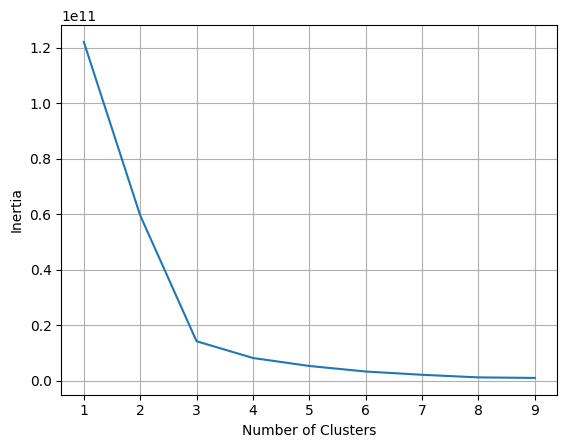

In [267]:
# Elbow method
def optimize_k_means(data, max_k):
  means    = []
  inertias = []

  for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)

    means.append(k)
    inertias.append(kmeans.inertia_)

  plt.plot(means, inertias)
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

optimize_k_means(data[['Price', 'Peak CCU']], 10)

In [268]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_for_clustering])
data_scaled

array([[22.89293918, -0.07456263,  0.69911194],
       [22.89293918, -0.86674221,  0.9318364 ],
       [22.89293918, -0.86674221,  0.70974242],
       ...,
       [-0.19710487, -0.66388077, -1.38213349],
       [-0.19710487, -0.86674221, -1.38213349],
       [-0.19710487, -0.86674221, -1.38213349]], shape=(20106, 3))

In [25]:
# pca_2 = PCA(n_components=2)
# pca_2_result = pca_2.fit_transform(data_scaled)
# print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

In [26]:
# dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=columns_for_clustering, index=['PC_1', 'PC_2'])
# print('\n\n', dataset_pca)

In [27]:
# # Silhouette score
# parameters = [2, 3, 4, 5, 6, 7]
# # instantiating ParameterGrid, pass number of clusters as input
# parameter_grid = ParameterGrid({'n_clusters': parameters})
# best_score = -1
# kmeans_model = KMeans()     # instantiating KMeans model
# silhouette_scores = []
# # evaluation based on silhouette_score
# for p in parameter_grid:
#     kmeans_model.set_params(**p)    # set current hyper parameter
#     kmeans_model.fit(data_scaled)          # fit model on wine dataset, this will find clusters based on parameter p
#     ss = metrics.silhouette_score(data_scaled, kmeans_model.labels_)   # calculate silhouette_score
#     silhouette_scores += [ss]       # store all the scores
#     print('Parameter:', p, 'Score', ss)
#     # check p which has the best score
#     if ss > best_score:
#         best_score = ss
#         best_grid = p
# # plotting silhouette score
# plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', width=0.5)
# plt.xticks(range(len(silhouette_scores)), list(parameters))
# plt.title('Silhouette Score', fontweight='bold')
# plt.xlabel('Number of Clusters')
# plt.show()

In [52]:
# def process_cluster(cluster_count):
#     kmeans = KMeans(n_clusters=cluster_count, random_state=35)
#     kmeans.fit(data[columns_for_clustering])

#     # Add cluster labels to the original DataFrame
#     data['Cluster'] = kmeans.labels_


#     # Plot the clusters
#     plt.figure(figsize=(10, 10))
#     for cluster in data['Cluster'].unique():
#         plt.scatter(
#             pca_2_result[data['Cluster'] == cluster, 0],
#             pca_2_result[data['Cluster'] == cluster, 1],
#             label=f'Cluster {cluster}'
#         )

#     plt.title('K-Means Clustering Visualization')
#     plt.xlabel('PCA1')
#     plt.ylabel('PCA2')
#     plt.legend()
#     plt.show()

In [ ]:
# process_cluster(2)

In [ ]:
# process_cluster(3)

In [235]:
# process_cluster(4)

In [236]:
# process_cluster(5)

In [269]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

# Add cluster labels to the DataFrame
data['Cluster'] = kmeans.labels_

In [289]:
colors = {
    0: 'red', 
    1: 'blue', 
    2: 'orange'
}

def show_plt(feature_1, feature_2, width = 20, height = 10):
    plt.figure(figsize=(width, height))
    
    for cluster in sorted(c for c in data['Cluster'].unique()):
        plt.scatter(
            data[data['Cluster'] == cluster][feature_1],
            data[data['Cluster'] == cluster][feature_2],
            color=colors.get(cluster),
            label=f'Cluster {cluster}'
        )

    # Plot cluster 2 last (on top)
    # if 2 in data['Cluster'].unique():
    #     plt.scatter(
    #         data[data['Cluster'] == 2][feature_1],
    #         data[data['Cluster'] == 2][feature_2],
    #         color=colors.get(cluster),
    #         label='Cluster 2'
    #     )
    plt.title('K-Means Clustering Visualization')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.legend()
    plt.show()

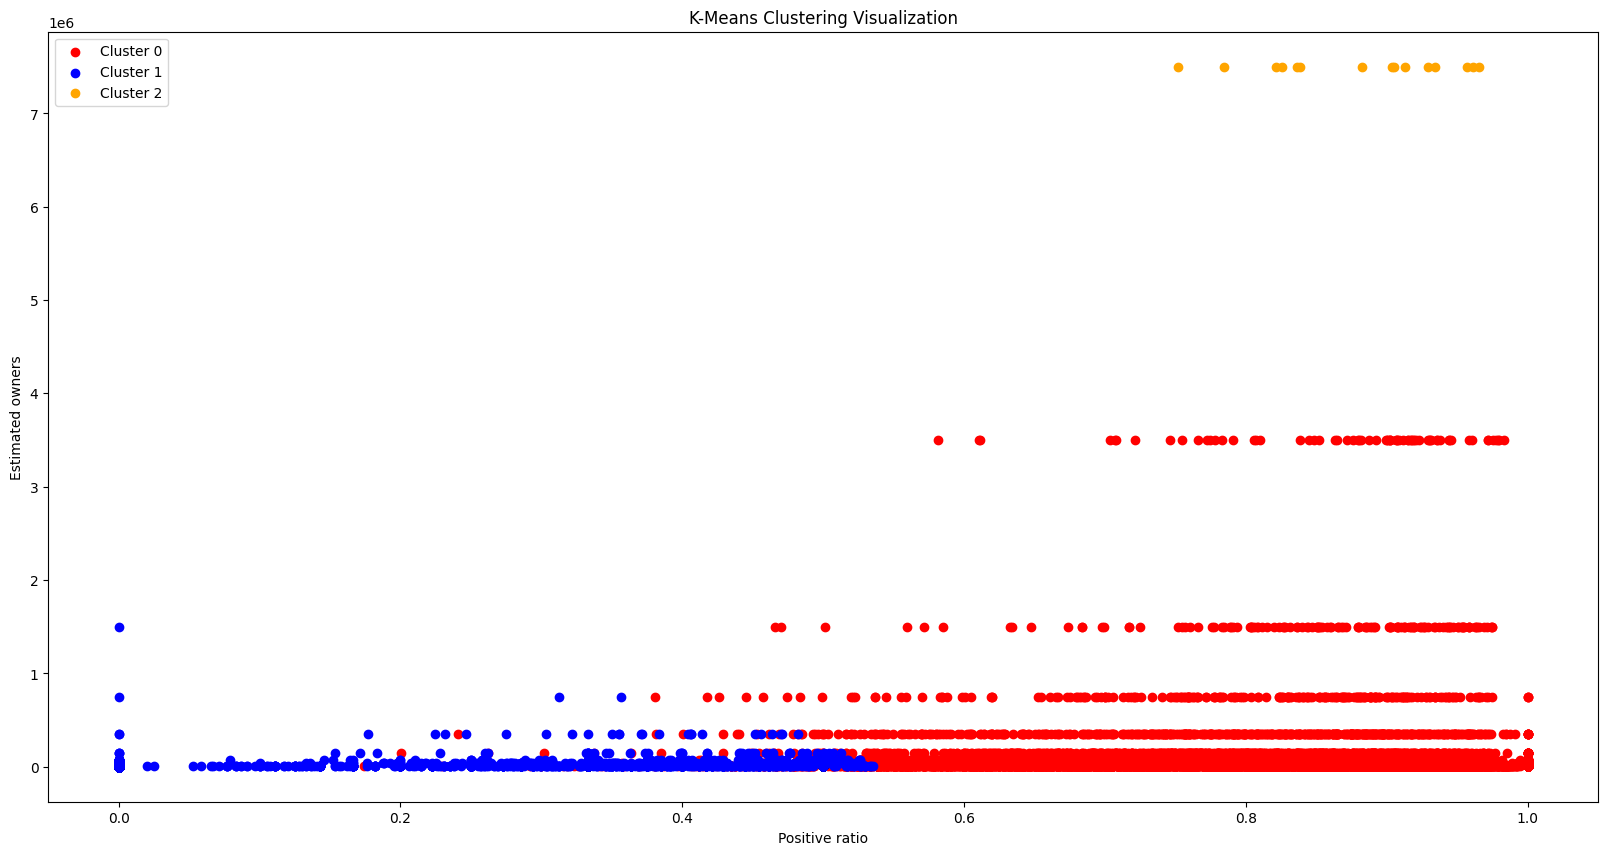

In [290]:
show_plt('Positive ratio', 'Estimated owners')

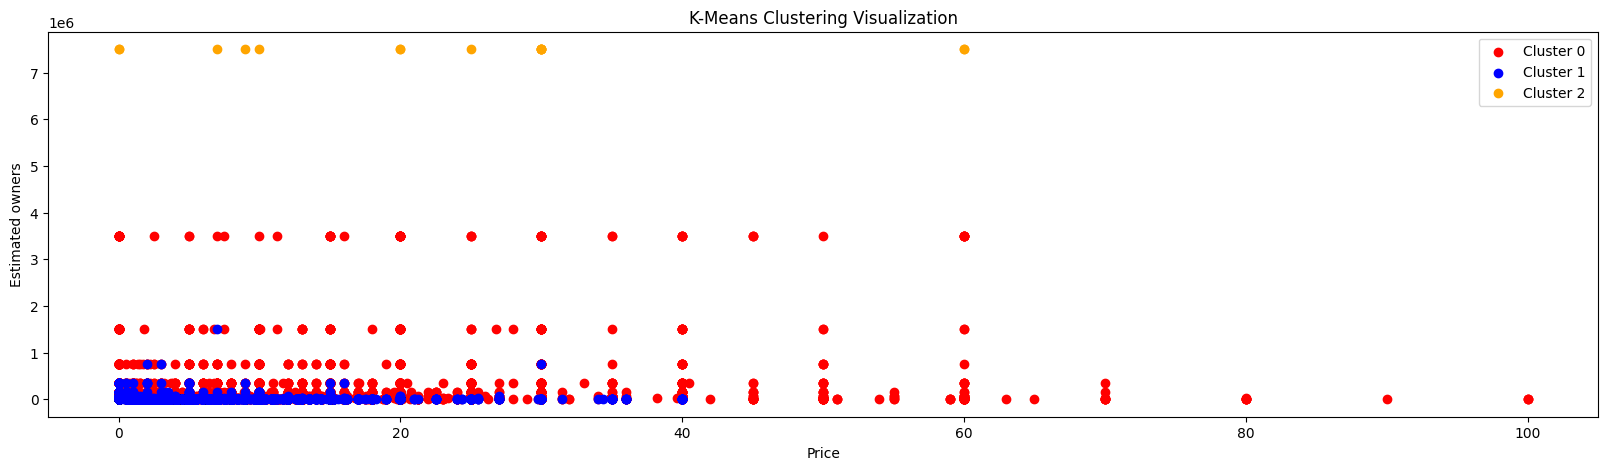

In [291]:
show_plt('Price', 'Estimated owners', 20, 5)

In [287]:
# show_plt('Estimated owners', 'Supported OS', 20,5)

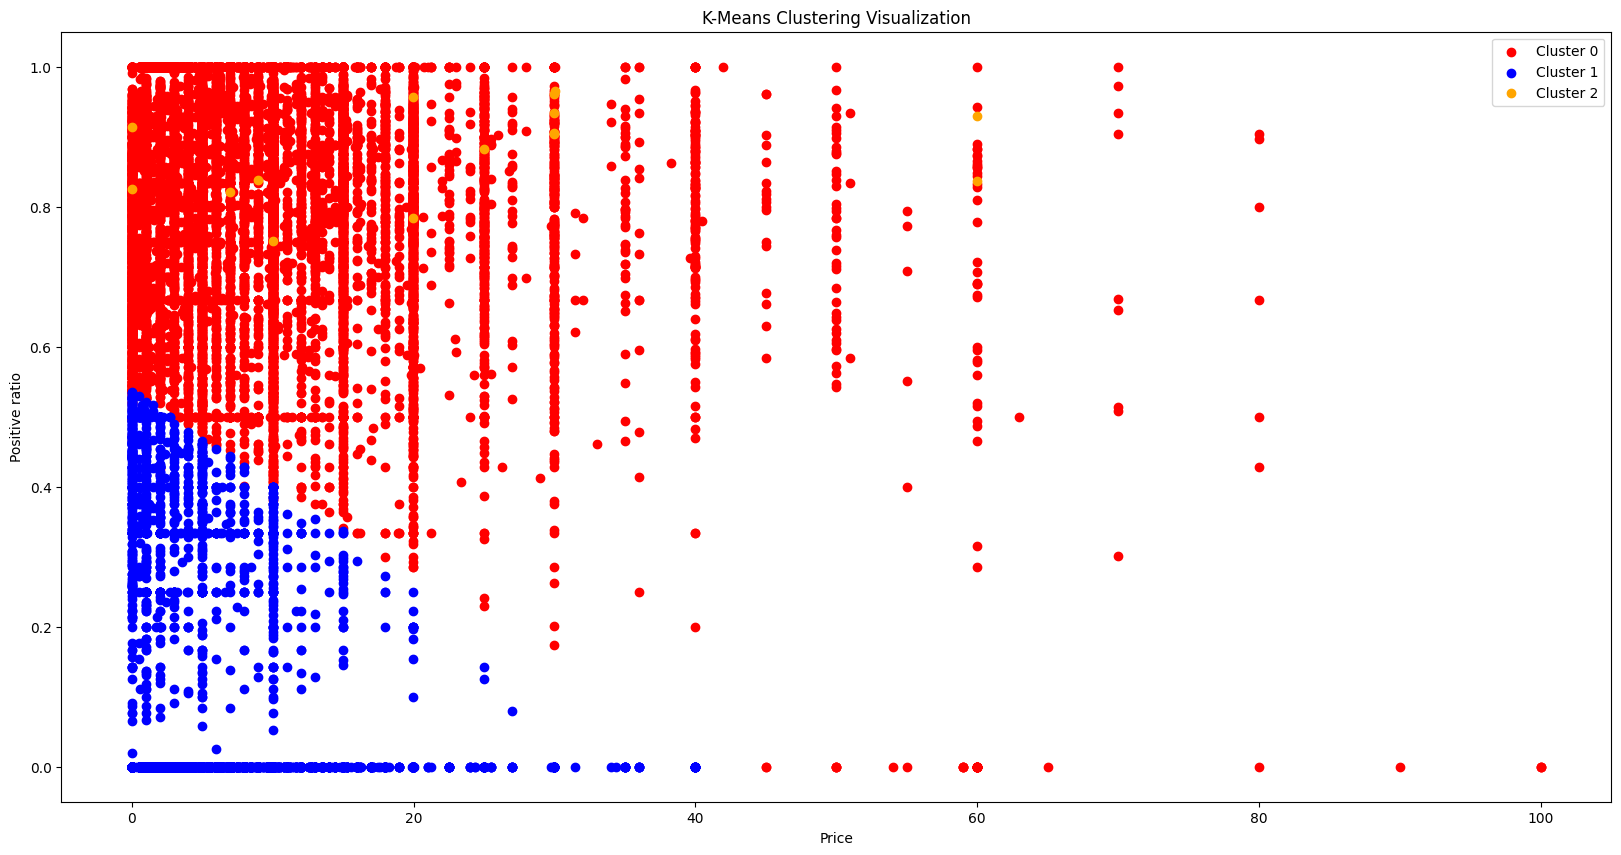

In [292]:
show_plt('Price', 'Positive ratio', 20, 10)

In [294]:
# show_plt('Positive ratio', 'Supported OS', 20, 5)